In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   ##绘图库

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为新宋体。
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时'-'显示为方块的问题。

from sklearn.model_selection import train_test_split   ## 划分

import torch

from sklearn.model_selection import train_test_split   #训练集测试集划分
from sklearn.ensemble import RandomForestClassifier    #随机森林相关库
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score        #模型精度评分
from sklearn.metrics import confusion_matrix           #混淆矩阵表
from sklearn import svm  #支持向量机

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # 使用 CPU
    print("Using CPU")


Using GPU: NVIDIA GeForce MX450


In [8]:
# 加载 csv文件
merged_data = pd.read_csv('merged_data.csv')

data = merged_data.drop(['AQI','PM2.5','PM10','NO2','CO','SO2','O3_8h'],axis=1)
# 检查结果
data

,日期,气温,气压,平均海平面大气压,气压趋势,湿度,风向,平均风速,最大阵风,天气情况,最低气温,最高气温,露点温度,降水时间,季节,质量等级
0,2013-12-02,3.162,759.712,764.462,-0.013,45.875,7.375,1.375,7.177,5.500,6.896,18.301,-8.588,10.717,冬,轻度污染
1,2013-12-03,5.488,761.725,766.425,0.100,39.000,8.000,1.625,7.177,4.750,7.209,18.314,-8.900,10.717,冬,良
2,2013-12-04,5.250,760.300,764.988,-0.138,45.375,9.375,1.250,7.177,1.750,7.134,18.714,-6.675,10.717,冬,轻度污染
3,2013-12-05,6.150,763.275,767.975,0.250,30.000,6.875,2.250,7.177,3.875,7.759,18.551,-10.912,10.717,冬,良
4,2013-12-06,2.925,760.325,765.075,-0.275,52.750,4.875,1.250,7.177,1.000,7.121,18.239,-6.350,10.717,冬,中度污染
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,2023-12-26,-2.050,770.638,773.938,0.925,54.125,8.250,1.500,7.147,0.500,-9.475,2.588,-10.862,12.000,冬,良
3677,2023-12-27,-3.888,771.538,774.850,-0.538,67.750,7.250,1.125,4.250,0.000,-8.900,5.348,-9.450,12.000,冬,良
3678,2023-12-28,-3.012,769.138,772.438,-0.038,69.875,6.625,1.000,3.750,0.375,-9.100,3.750,-8.288,12.000,冬,轻度污染
3679,2023-12-29,-2.800,765.112,768.400,-0.938,78.125,5.625,1.125,4.147,2.000,-6.302,3.975,-6.300,12.000,冬,轻度污染


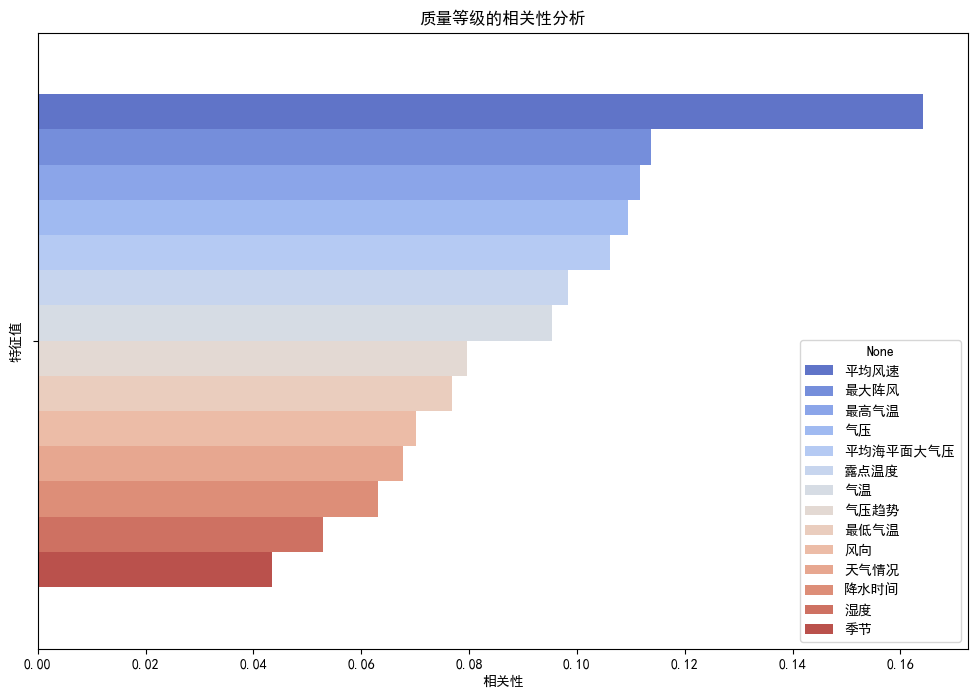

质量等级        1.000000
平均风速        0.164287
最大阵风        0.113761
最高气温        0.111750
气压          0.109454
平均海平面大气压    0.106138
露点温度        0.098350
气温          0.095311
气压趋势        0.079601
最低气温        0.076747
风向          0.070087
天气情况        0.067813
降水时间        0.063081
湿度          0.052930
季节          0.043512
Name: 质量等级, dtype: float64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# 初始化标签编码器
le = LabelEncoder()

# 对质量等级进行编码
data['质量等级'] = le.fit_transform(data['质量等级'])
data['季节'] = le.fit_transform(data['季节'])

# 选择特定的特征列
selected_features = ['气温', '气压', '平均海平面大气压', '气压趋势', '湿度', '风向', '平均风速', '最大阵风', '天气情况', '最低气温', '最高气温', '露点温度', '降水时间', '季节', '质量等级']

# 计算选定特征列的相关性
correlation = data[selected_features].corr()['质量等级']

correlation = correlation.abs()

# 按照绝对值降序排序
correlation = correlation.reindex(correlation.abs().sort_values(ascending=False).index)

# 创建一个条形图
plt.figure(figsize=(12, 8))
sns.barplot(x=correlation[1:], hue = correlation.index[1:], legend = 'auto', palette='coolwarm')

# 添加标题和标签
plt.title('质量等级的相关性分析')
plt.xlabel('相关性')
plt.ylabel('特征值')

# 显示图表
plt.show()

print(correlation)

划分训练集，尽可能地减少对难预测的空气污染物成分的依赖

In [10]:
# 将data的值复制到df当中
df = merged_data


# 执行独热编码转换类别字段
df = pd.get_dummies(df, columns=['季节'])


# 预测前，将数据集划分为训练集和验证集，尽可能地减少对难预测的空气污染物成分的依赖
X = df.drop(columns=['质量等级','日期','AQI','O3_8h','NO2','SO2'])
y = df['质量等级']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




使用随机森林的默认状态进行调试

随机森林参数调优

预测的准确率是： 0.8168249660786974


,准确率,召回率,精确率,F1
训练集,0.920177,0.920177,0.921693,0.918641
测试集,0.816825,0.816825,0.819219,0.815129


,真实值,预测值,严重污染预测概率,中度污染预测概率,优预测概率,无预测概率,良预测概率,轻度污染预测概率,重度污染预测概率
1097,严重污染,重度污染,0.242753,0.028671,0.000000,0.000000,0.007273,0.003818,0.717485
2784,优,优,0.002857,0.003500,0.580033,0.000000,0.355595,0.058015,0.000000
2440,良,良,0.000000,0.035993,0.159627,0.002500,0.588910,0.212970,0.000000
1694,优,优,0.001538,0.008901,0.475104,0.000000,0.389171,0.119131,0.006154
2494,良,良,0.000000,0.000000,0.163351,0.002500,0.757525,0.076624,0.000000
2270,轻度污染,轻度污染,0.000000,0.168943,0.012083,0.000000,0.035368,0.750467,0.033139
3477,良,良,0.000000,0.008205,0.188131,0.001250,0.676005,0.125076,0.001333
937,良,中度污染,0.000000,0.530691,0.000000,0.000000,0.141202,0.304054,0.024053
495,中度污染,中度污染,0.064650,0.449891,0.012000,0.000000,0.082585,0.196608,0.194265
798,重度污染,重度污染,0.120026,0.219474,0.015000,0.000000,0.092429,0.229477,0.323595


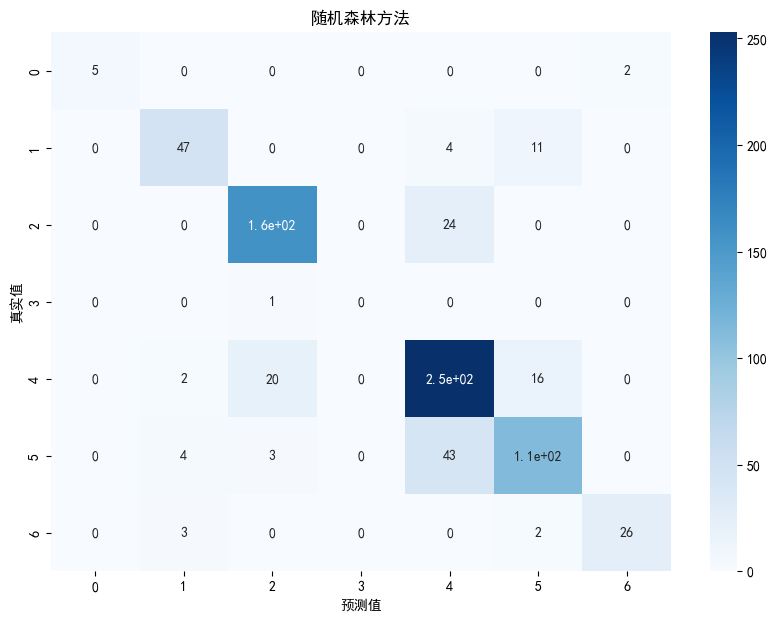

In [11]:

# 使用随机森林分类器进行训练
# classifier = RandomForestClassifier(n_estimators=120, random_state=42)
## 参数调优 
classifier = RandomForestClassifier(n_estimators=50, 
                                    min_samples_leaf=5, 
                                    min_samples_split=10, 
                                    random_state=42)

classifier.fit(X_train, y_train)

# 进行预测并检查准确率
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("预测的准确率是：", accuracy)
# 概率
predicted_proba = classifier.predict_proba(X_test)

# 计算混淆矩阵并创建热力图
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.title('随机森林方法')
plt.xlabel('预测值')
plt.ylabel('真实值')



# 训练集上的预测
train_predictions = classifier.predict(X_train)
# 计算准确率、召回率、精确率 和 F1分数
accuracy_train = classifier.score(X_train, y_train)
recall_train = recall_score(y_train, train_predictions, average='weighted')
precision_train = precision_score(y_train, train_predictions, average='weighted',zero_division=1)
f1_train = f1_score(y_train, train_predictions, average='weighted')
accuracy_test = accuracy
recall_test = recall_score(y_test, predictions, average='weighted')
precision_test = precision_score(y_test, predictions, average='weighted',zero_division=1)
f1_test = f1_score(y_test, predictions, average='weighted')
# 创建 DataFrame
performance = pd.DataFrame({
    '准确率': [accuracy_train, accuracy_test],
    '召回率': [recall_train, recall_test],
    '精确率': [precision_train, precision_test],
    'F1': [f1_train, f1_test]
}, index = ['训练集', '测试集'])
# 显示 performance
performance_styler = performance.style.set_properties(**{'text-align': 'center'})
display(performance_styler)
# 构建预测结果对照表
results = pd.DataFrame({
    '真实值': y_test,
    '预测值': predictions
})

# 获得类别列表，按照模型内部的顺序
class_list = classifier.classes_

# 将预测的概率与其对应的类别关联起来
for i, quality_level in enumerate(class_list):
    results[f'{quality_level}预测概率'] = predicted_proba[:, i]

# 使用 .head() 方法获取前20条数据
results_head = results.head(20)

# 设置数据显示为居中格式
results_styler = results_head.style.set_properties(**{'text-align': 'center'})

# 显示居中对齐的前100条数据
display(results_styler)



支持向量机分类算法

预测准确率： 0.7584803256445047
预测的准确率是： 0.7584803256445047


,准确率,召回率,精确率,F1
训练集,0.754416,0.754416,0.753321,0.751580
测试集,0.758480,0.758480,0.757210,0.755971


,真实值,预测值,严重污染预测概率,中度污染预测概率,优预测概率,无预测概率,良预测概率,轻度污染预测概率,重度污染预测概率
1097,严重污染,重度污染,0.300962,0.053690,0.002110,0.002733,0.001727,0.005712,0.633066
2784,优,良,0.001050,0.005165,0.331282,0.001943,0.618779,0.041574,0.000207
2440,良,良,0.001645,0.022439,0.061227,0.001645,0.718252,0.193896,0.000895
1694,优,优,0.003246,0.005873,0.672221,0.005097,0.286800,0.025789,0.000974
2494,良,良,0.001708,0.006182,0.043863,0.000259,0.844592,0.101828,0.001568
2270,轻度污染,轻度污染,0.002498,0.370101,0.001685,0.001179,0.161089,0.424686,0.038762
3477,良,良,0.000512,0.032570,0.332566,0.001983,0.524911,0.104358,0.003101
937,良,中度污染,0.003020,0.459037,0.002037,0.000806,0.056424,0.465143,0.013532
495,中度污染,中度污染,0.014296,0.516219,0.002520,0.002577,0.042034,0.322502,0.099852
798,重度污染,严重污染,0.136483,0.412313,0.015048,0.007002,0.021073,0.056832,0.351248


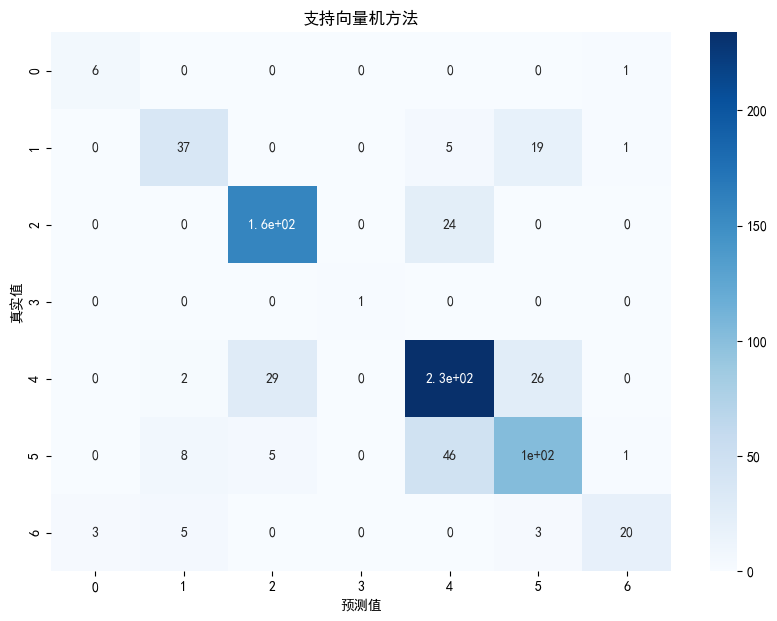

In [12]:

# 使用支持向量机分类器进行训练
# 默认参数
# classifier = svm.SVC(probability=True)
# classifier.fit(X_train, y_train)


# 参数调优
classifier = svm.SVC(probability=True, C=0.8, kernel='linear', gamma=0.01)
classifier.fit(X_train, y_train)

# 执行预测并计算准确度
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("预测准确率：", accuracy)

# 概率
predicted_proba = classifier.predict_proba(X_test)

# 进行预测并检查准确率
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("预测的准确率是：", accuracy)
# 概率
predicted_proba = classifier.predict_proba(X_test)

# 计算混淆矩阵并创建热力图
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.title('支持向量机方法')
plt.xlabel('预测值')
plt.ylabel('真实值')



# 训练集上的预测
train_predictions = classifier.predict(X_train)
# 计算准确率、召回率、精确率 和 F1分数
accuracy_train = classifier.score(X_train, y_train)
recall_train = recall_score(y_train, train_predictions, average='weighted')
precision_train = precision_score(y_train, train_predictions, average='weighted',zero_division=1)
f1_train = f1_score(y_train, train_predictions, average='weighted')
accuracy_test = accuracy
recall_test = recall_score(y_test, predictions, average='weighted')
precision_test = precision_score(y_test, predictions, average='weighted',zero_division=1)
f1_test = f1_score(y_test, predictions, average='weighted')
# 创建 DataFrame
performance = pd.DataFrame({
    '准确率': [accuracy_train, accuracy_test],
    '召回率': [recall_train, recall_test],
    '精确率': [precision_train, precision_test],
    'F1': [f1_train, f1_test]
}, index = ['训练集', '测试集'])
# 显示 performance
performance_styler = performance.style.set_properties(**{'text-align': 'center'})
display(performance_styler)
# 构建预测结果对照表
results = pd.DataFrame({
    '真实值': y_test,
    '预测值': predictions
})

# 获得类别列表，按照模型内部的顺序
class_list = classifier.classes_

# 将预测的概率与其对应的类别关联起来
for i, quality_level in enumerate(class_list):
    results[f'{quality_level}预测概率'] = predicted_proba[:, i]

# 使用 .head() 方法获取前20条数据
results_head = results.head(20)

# 设置数据显示为居中格式
results_styler = results_head.style.set_properties(**{'text-align': 'center'})

# 显示居中对齐的前100条数据
display(results_styler)

